In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from textpruner import summary, TransformerPruner, TransformerPruningConfig
import os
os.environ['TRANSFORMERS_CACHE'] = "/mnt/swordfish-pool2/harsha"
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("philschmid/roberta-large-sst2")

model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")

In [3]:
print("Before pruning:")
print(summary(model))

Before pruning:

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    355,362,308	   100.00%	 1355.60
  --roberta:     	    354,310,658	    99.70%	 1351.59
    --embeddings:	     52,001,282	    14.63%	  198.37
    --encoder:   	    302,309,376	    85.07%	 1153.22
  --classifier:  	      1,051,650	     0.30%	    4.01
    --dense:     	      1,049,600	     0.30%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



In [4]:
from datasets import load_dataset

dataset = load_dataset("sst2")

Found cached dataset sst2 (/home/hv2237/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [6]:
eval_dataset = dataset['validation'].map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length'), batched=True)

Loading cached processed dataset at /home/hv2237/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-765d3ac95c2537c3.arrow


In [7]:
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [8]:
eval_dataset = eval_dataset.rename_column('label','labels')

In [9]:
import torch
dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)

In [10]:
def adatpor(model_outputs):
    logits = model_outputs.logits
    return logits #entropy(logits)


transformer_pruning_config = TransformerPruningConfig(
    target_ffn_size=1536, target_num_of_heads=6, 
    pruning_method='iterative',n_iters=8,use_logits=True,head_even_masking=False,ffn_even_masking=False)
pruner = TransformerPruner(model,transformer_pruning_config=transformer_pruning_config)   
pruner.prune(dataloader=dataloader, save_model=False, adaptor=adatpor)


ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.12s/it]


In [11]:
print("After pruning:")
print(summary(model))

for i in range(12):
    print ((model.base_model.encoder.layer[i].intermediate.dense.weight.shape,
            model.base_model.encoder.layer[i].intermediate.dense.bias.shape,
            model.base_model.encoder.layer[i].attention.self.key.weight.shape))


After pruning:

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    166,511,108	   100.00%	  635.19
  --roberta:     	    165,459,458	    99.37%	  631.18
    --embeddings:	     52,001,282	    31.23%	  198.37
    --encoder:   	    113,458,176	    68.14%	  432.81
  --classifier:  	      1,051,650	     0.63%	    4.01
    --dense:     	      1,049,600	     0.63%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01

(torch.Size([294, 1024]), torch.Size([294]), torch.Size([640, 1024]))
(torch.Size([575, 1024]), torch.Size([575]), torch.Size([512, 1024]))
(torch.Size([1294, 1024]), torch.Size([1294]), torch.Size([512, 1024]))
(torch.Size([2430, 1024]), torch.Size([2430]), torch.Size([576, 1024]))
(torch.Size([2465, 1024]), torch.Size([2465]), torch.Size([576, 1024]))
(torch.Size([2108, 1024]), torch.Size([2108]), torch.Size([576, 1024]))
(torch.Size([2022, 1024]), torch.Size([2022]), torch.Size([576, 1024]))
(torch.Size([1947, 1024]), torch.Size([1947]), torc

In [13]:
from transformers import TrainingArguments, Trainer
import evaluate


In [17]:
training_args = TrainingArguments(
    output_dir='/mnt/swordfish-pool2/harsha/hpml',          #output directory
    # learning_rate=1e-4,
    # num_train_epochs=50,              
    # per_device_train_batch_size=8,                #batch size per device during training
    per_device_eval_batch_size=16,                #batch size for evaluation
    # logging_dir='/content/drive/MyDrive/logs',            
    # logging_steps=100,
    # do_train=True,
    do_eval=True,
    no_cuda=False,
    # load_best_model_at_end=True,
    # save_strategy="epoch",
    # # eval_steps=100,
    # metric_for_best_model = 'eval_loss',
    # evaluation_strategy="epoch"
)
acc = evaluate.load("accuracy")
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(inputs)
    predictions = np.argmax(logits, axis=-1)
    
    return {
        'accuracy': acc.compute(predictions=predictions, references=labels),
        # 'precision': prec.compute(predictions=predictions, references=labels),
        # 'recall': rec.compute(predictions=predictions, references=labels),
        # 'f1': f1.compute(predictions=predictions, references=labels)
    }


In [19]:
for heads in [10,8,6,4]:

    model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")

    transformer_pruning_config = TransformerPruningConfig(
        target_ffn_size=1536, target_num_of_heads=heads, 
        pruning_method='iterative',n_iters=8,use_logits=True,head_even_masking=False,ffn_even_masking=False)
    pruner = TransformerPruner(model,transformer_pruning_config=transformer_pruning_config)   
    pruner.prune(dataloader=dataloader, save_model=False, adaptor=adatpor)

    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        compute_metrics=compute_metrics,
    )
    print(f'Heads: {heads}')
    print(summary(model))
    trainer.evaluate(eval_dataset)

ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 10

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    191,695,364	   100.00%	  731.26
  --roberta:     	    190,643,714	    99.45%	  727.25
    --embeddings:	     52,001,282	    27.13%	  198.37
    --encoder:   	    138,642,432	    72.32%	  528.88
  --classifier:  	      1,051,650	     0.55%	    4.01
    --dense:     	      1,049,600	     0.55%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.8405963302752294}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 8

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    179,103,236	   100.00%	  683.23
  --roberta:     	    178,051,586	    99.41%	  679.21
    --embeddings:	     52,001,282	    29.03%	  198.37
    --encoder:   	    126,050,304	    70.38%	  480.84
  --classifier:  	      1,051,650	     0.59%	    4.01
    --dense:     	      1,049,600	     0.59%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.7557339449541285}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 6

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    166,511,108	   100.00%	  635.19
  --roberta:     	    165,459,458	    99.37%	  631.18
    --embeddings:	     52,001,282	    31.23%	  198.37
    --encoder:   	    113,458,176	    68.14%	  432.81
  --classifier:  	      1,051,650	     0.63%	    4.01
    --dense:     	      1,049,600	     0.63%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.7522935779816514}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 4

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    153,918,980	   100.00%	  587.16
  --roberta:     	    152,867,330	    99.32%	  583.14
    --embeddings:	     52,001,282	    33.78%	  198.37
    --encoder:   	    100,866,048	    65.53%	  384.77
  --classifier:  	      1,051,650	     0.68%	    4.01
    --dense:     	      1,049,600	     0.68%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.713302752293578}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [20]:
model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")
trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        compute_metrics=compute_metrics,
    )
trainer.evaluate(eval_dataset)

Trainer is attempting to log a value of "{'accuracy': 0.9644495412844036}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.13996513187885284,
 'eval_accuracy': {'accuracy': 0.9644495412844036},
 'eval_runtime': 20.6714,
 'eval_samples_per_second': 42.184,
 'eval_steps_per_second': 5.273}

In [21]:
for i in range(12):
    print ((model.base_model.encoder.layer[i].intermediate.dense.weight.shape,
            model.base_model.encoder.layer[i].intermediate.dense.bias.shape,
            model.base_model.encoder.layer[i].attention.self.key.weight.shape))

(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))
(torch.Size([4096, 1024]), torch.Size([4096]), torch.Size([1024, 1024]))


In [26]:
for heads in [10,8,6,4]:

    model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")

    transformer_pruning_config = TransformerPruningConfig(
        target_ffn_size=4096, target_num_of_heads=heads, 
        pruning_method='iterative',n_iters=8,use_logits=True,head_even_masking=False,ffn_even_masking=False)
    pruner = TransformerPruner(model,transformer_pruning_config=transformer_pruning_config)   
    pruner.prune(dataloader=dataloader, save_model=False, adaptor=adatpor)

    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        compute_metrics=compute_metrics,
    )
    print(f'Heads: {heads}')
    print(summary(model))
    trainer.evaluate(eval_dataset)

ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 10

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    317,585,924	   100.00%	 1211.50
  --roberta:     	    316,534,274	    99.67%	 1207.48
    --embeddings:	     52,001,282	    16.37%	  198.37
    --encoder:   	    264,532,992	    83.29%	 1009.11
  --classifier:  	      1,051,650	     0.33%	    4.01
    --dense:     	      1,049,600	     0.33%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.9621559633027523}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 8

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    304,993,796	   100.00%	 1163.46
  --roberta:     	    303,942,146	    99.66%	 1159.45
    --embeddings:	     52,001,282	    17.05%	  198.37
    --encoder:   	    251,940,864	    82.61%	  961.08
  --classifier:  	      1,051,650	     0.34%	    4.01
    --dense:     	      1,049,600	     0.34%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.9610091743119266}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 6

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    292,401,668	   100.00%	 1115.43
  --roberta:     	    291,350,018	    99.64%	 1111.41
    --embeddings:	     52,001,282	    17.78%	  198.37
    --encoder:   	    239,348,736	    81.86%	  913.04
  --classifier:  	      1,051,650	     0.36%	    4.01
    --dense:     	      1,049,600	     0.36%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.9529816513761468}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 4

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    279,809,540	   100.00%	 1067.39
  --roberta:     	    278,757,890	    99.62%	 1063.38
    --embeddings:	     52,001,282	    18.58%	  198.37
    --encoder:   	    226,756,608	    81.04%	  865.01
  --classifier:  	      1,051,650	     0.38%	    4.01
    --dense:     	      1,049,600	     0.38%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.9288990825688074}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [29]:
for heads in [2,1]:

    model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")

    transformer_pruning_config = TransformerPruningConfig(
        target_ffn_size=4096, target_num_of_heads=heads, 
        pruning_method='iterative',n_iters=8,use_logits=True,head_even_masking=False,ffn_even_masking=False)
    pruner = TransformerPruner(model,transformer_pruning_config=transformer_pruning_config)   
    pruner.prune(dataloader=dataloader, save_model=False, adaptor=adatpor)

    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        compute_metrics=compute_metrics,
    )
    print(f'Heads: {heads}')
    print(summary(model))
    trainer.evaluate(eval_dataset)

ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.12s/it]


Warning
Warning
Warning
Warning
Warning
Heads: 2

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    268,529,092	   100.00%	 1024.36
  --roberta:     	    267,477,442	    99.61%	 1020.35
    --embeddings:	     52,001,282	    19.37%	  198.37
    --encoder:   	    215,476,160	    80.24%	  821.98
  --classifier:  	      1,051,650	     0.39%	    4.01
    --dense:     	      1,049,600	     0.39%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.8658256880733946}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.12s/it]


Warning


Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Heads: 1

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    264,069,380	   100.00%	 1007.35
  --roberta:     	    263,017,730	    99.60%	 1003.33
    --embeddings:	     52,001,282	    19.69%	  198.37
    --encoder:   	    211,016,448	    79.91%	  804.96
  --classifier:  	      1,051,650	     0.40%	    4.01
    --dense:     	      1,049,600	     0.40%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.6169724770642202}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [23]:
from transformers import RobertaConfig

In [24]:
config = RobertaConfig.from_pretrained('roberta-large')

In [25]:
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [28]:
for ffn in [2048,1024,512]:

    model = AutoModelForSequenceClassification.from_pretrained("philschmid/roberta-large-sst2")

    transformer_pruning_config = TransformerPruningConfig(
        target_ffn_size=ffn, target_num_of_heads=12, 
        pruning_method='iterative',n_iters=8,use_logits=True,head_even_masking=False,ffn_even_masking=False)
    pruner = TransformerPruner(model,transformer_pruning_config=transformer_pruning_config)   
    pruner.prune(dataloader=dataloader, save_model=False, adaptor=adatpor)

    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        compute_metrics=compute_metrics,
    )
    print(f'Heads: {heads}')
    print(summary(model))
    trainer.evaluate(eval_dataset)

ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.12s/it]


Heads: 4

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    229,465,604	   100.00%	  875.34
  --roberta:     	    228,413,954	    99.54%	  871.33
    --embeddings:	     52,001,282	    22.66%	  198.37
    --encoder:   	    176,412,672	    76.88%	  672.96
  --classifier:  	      1,051,650	     0.46%	    4.01
    --dense:     	      1,049,600	     0.46%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.9506880733944955}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.12s/it]


Heads: 4

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    179,109,380	   100.00%	  683.25
  --roberta:     	    178,057,730	    99.41%	  679.24
    --embeddings:	     52,001,282	    29.03%	  198.37
    --encoder:   	    126,056,448	    70.38%	  480.87
  --classifier:  	      1,051,650	     0.59%	    4.01
    --dense:     	      1,049,600	     0.59%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.819954128440367}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
ffn_even_masking is False. Pruned model can only be save in TorchScript format manually.
Calculating IS with logits: 100%|███████████████| 55/55 [01:01<00:00,  1.11s/it]


Heads: 4

LAYER NAME       	        #PARAMS	     RATIO	 MEM(MB)
--model:         	    153,931,268	   100.00%	  587.20
  --roberta:     	    152,879,618	    99.32%	  583.19
    --embeddings:	     52,001,282	    33.78%	  198.37
    --encoder:   	    100,878,336	    65.53%	  384.82
  --classifier:  	      1,051,650	     0.68%	    4.01
    --dense:     	      1,049,600	     0.68%	    4.00
    --out_proj:  	          2,050	     0.00%	    0.01



Trainer is attempting to log a value of "{'accuracy': 0.5206422018348624}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


# Hidden size vs Accuracy

In [30]:
import matplotlib.pyplot as plt

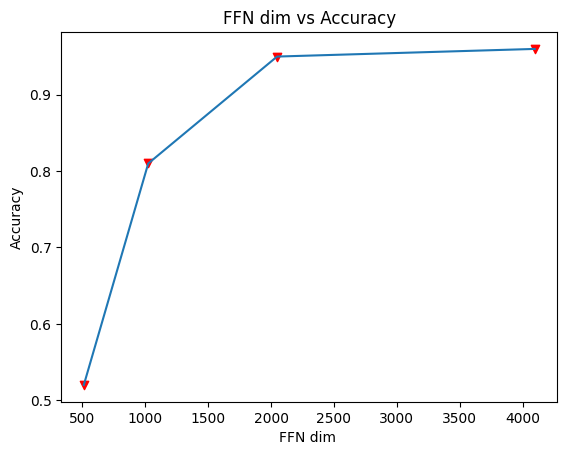

In [37]:
hidden = [4096,2048,1024,512]
accuracy = [0.96, 0.95,0.81,0.52]

# Plot the line
plt.plot(hidden, accuracy)
plt.scatter(hidden, accuracy, marker='v', color='r')
# Add a title and axis labels
plt.title("FFN dim vs Accuracy")
plt.xlabel("FFN dim ")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

# No of heads vs Accuracy

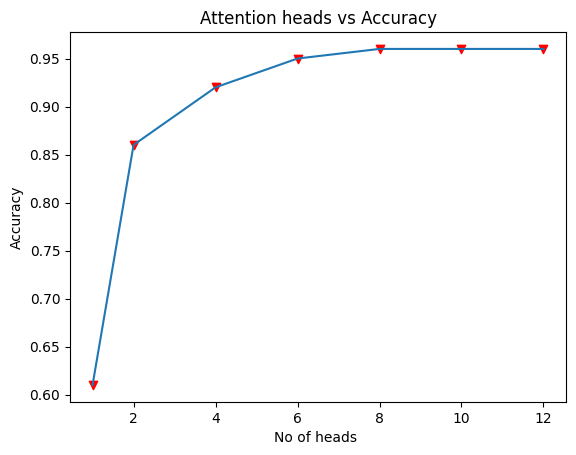

In [38]:
heads = [12,10,8,6,4,2,1]
accuracy = [0.96,0.96,0.96,0.95,0.92,0.86, 0.61]
plt.plot(heads, accuracy)
plt.scatter(heads, accuracy, marker='v', color='r')

# Add a title and axis labels
plt.title("Attention heads vs Accuracy")
plt.xlabel("No of heads ")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

# No of heads vs size of model

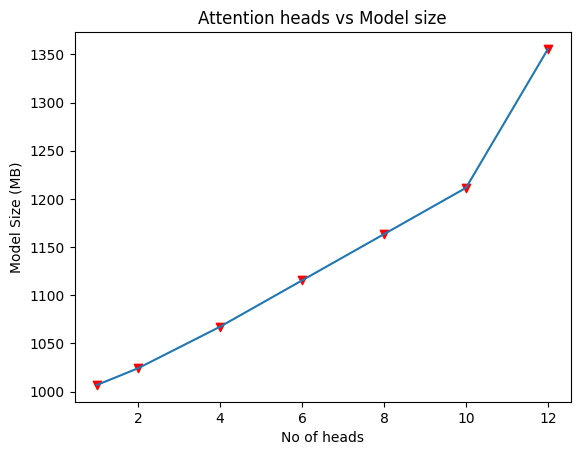

In [40]:
heads = [12,10,8,6,4,2,1]
modelsize = [1355.60, 1211.5, 1163.46, 1115.43, 1067.39, 1024.29, 1007]
plt.plot(heads, modelsize)
plt.scatter(heads, modelsize, marker='v', color='r')

# Add a title and axis labels
plt.title("Attention heads vs Model size")
plt.xlabel("No of heads")
plt.ylabel("Model Size (MB)")

# Show the plot
plt.show()

# Hidden Size vs size of model

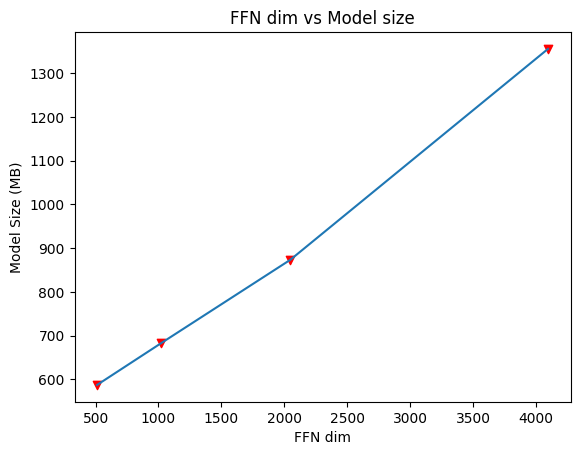

In [41]:
hidden = [4096,2048,1024,512]
modelsize = [1355.60, 873.34,683.25,587.20]
plt.plot(hidden, modelsize)
plt.scatter(hidden, modelsize, marker='v', color='r')

# Add a title and axis labels
plt.title("FFN dim vs Model size")
plt.xlabel("FFN dim")
plt.ylabel("Model Size (MB)")

# Show the plot
plt.show()